In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-10-05 14:17:35--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.106
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.73.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  17.1MB/s    in 1.5s    

2019-10-05 14:17:42 (17.1 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-10-05 14:17:44--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.50
Connecting to fashion-mnist.s3-website.eu-central-1.amazo

In [0]:
!mkdir MNIST_Fashion; cp *.gz MNIST_Fashion/

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

(1, 784)


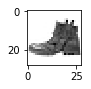

In [5]:
plt.figure(figsize=(1,1))
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

In [0]:
def discriminator(images, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Second convolutional and pool layers
    # This finds 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4

    # d4 contains unscaled values
    return d4

In [0]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [0]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [9]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

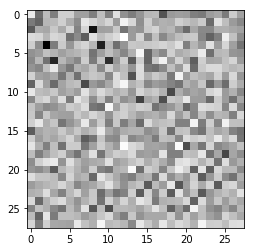

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [11]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse=True)
# Dg will hold discriminator prediction probabilities for generated images

In [12]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg,labels=tf.ones_like(Dg)))

In [14]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [0]:
# Train the discriminator
with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE) as scope:
  d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
  d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

  # Train the generator
  g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [16]:
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.6945917 dLossFake: 0.6905935
dLossReal: 0.10115917 dLossFake: 0.47362766
dLossReal: 0.07425648 dLossFake: 0.04862136
Iteration: 0 at 2019-10-05 14:18:42.459602


<Figure size 72x72 with 0 Axes>

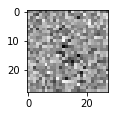

Estimate: [[-5.5568466]]
Iteration: 100 at 2019-10-05 14:18:47.459559


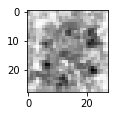

Estimate: [[-5.871174]]
Iteration: 200 at 2019-10-05 14:18:52.463403


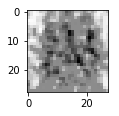

Estimate: [[-4.531945]]
Iteration: 300 at 2019-10-05 14:18:57.481646


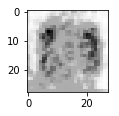

Estimate: [[1.8838041]]
Iteration: 400 at 2019-10-05 14:19:02.507827


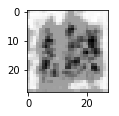

Estimate: [[-1.787763]]
Iteration: 500 at 2019-10-05 14:19:07.559873


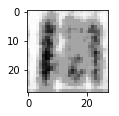

Estimate: [[-3.6595523]]
Iteration: 600 at 2019-10-05 14:19:12.767807


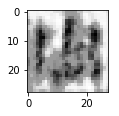

Estimate: [[-7.9946947]]
Iteration: 700 at 2019-10-05 14:19:17.832418


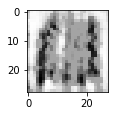

Estimate: [[-7.546798]]
Iteration: 800 at 2019-10-05 14:19:22.995981


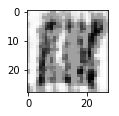

Estimate: [[1.7023705]]
Iteration: 900 at 2019-10-05 14:19:28.091678


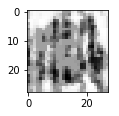

Estimate: [[-0.22697893]]
Iteration: 1000 at 2019-10-05 14:19:33.205942


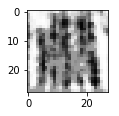

Estimate: [[1.7838807]]
Iteration: 1100 at 2019-10-05 14:19:38.354318


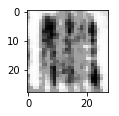

Estimate: [[-3.9904249]]
Iteration: 1200 at 2019-10-05 14:19:43.506405


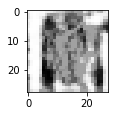

Estimate: [[-0.07452258]]
Iteration: 1300 at 2019-10-05 14:19:48.665468


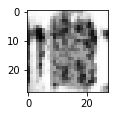

Estimate: [[-8.284612]]
Iteration: 1400 at 2019-10-05 14:19:53.883918


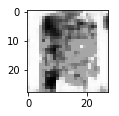

Estimate: [[-3.4670787]]
Iteration: 1500 at 2019-10-05 14:19:59.031077


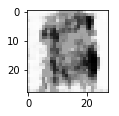

Estimate: [[-0.1644445]]
Iteration: 1600 at 2019-10-05 14:20:04.184692


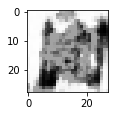

Estimate: [[1.1177486]]
Iteration: 1700 at 2019-10-05 14:20:09.331388


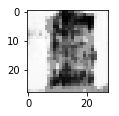

Estimate: [[2.1312275]]
Iteration: 1800 at 2019-10-05 14:20:14.480909


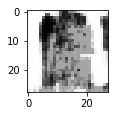

Estimate: [[-3.1579587]]
Iteration: 1900 at 2019-10-05 14:20:19.710273


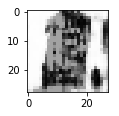

Estimate: [[0.19101834]]
Iteration: 2000 at 2019-10-05 14:20:24.874307


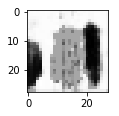

Estimate: [[-12.137762]]
Iteration: 2100 at 2019-10-05 14:20:30.044158


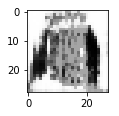

Estimate: [[-3.7451386]]
Iteration: 2200 at 2019-10-05 14:20:35.205958


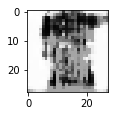

Estimate: [[4.0037546]]
Iteration: 2300 at 2019-10-05 14:20:40.573118


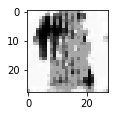

Estimate: [[0.97961545]]
Iteration: 2400 at 2019-10-05 14:20:45.752733


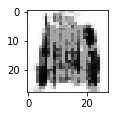

Estimate: [[-1.8980703]]
Iteration: 2500 at 2019-10-05 14:20:50.962593


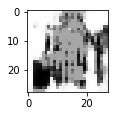

Estimate: [[-12.162538]]
Iteration: 2600 at 2019-10-05 14:20:56.145342


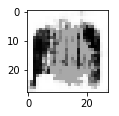

Estimate: [[20.507921]]
Iteration: 2700 at 2019-10-05 14:21:01.340369


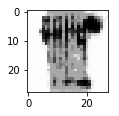

Estimate: [[-5.4421396]]
Iteration: 2800 at 2019-10-05 14:21:06.549328


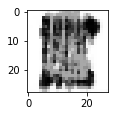

Estimate: [[4.6166563]]
Iteration: 2900 at 2019-10-05 14:21:11.754988


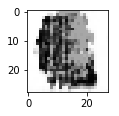

Estimate: [[-3.0325227]]
Iteration: 3000 at 2019-10-05 14:21:17.033252


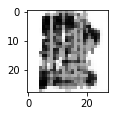

Estimate: [[-13.900222]]
Iteration: 3100 at 2019-10-05 14:21:22.229882


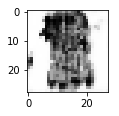

Estimate: [[-9.853546]]
Iteration: 3200 at 2019-10-05 14:21:27.451087


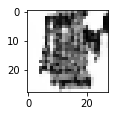

Estimate: [[-5.211073]]
Iteration: 3300 at 2019-10-05 14:21:32.662806


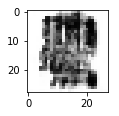

Estimate: [[8.572002]]
Iteration: 3400 at 2019-10-05 14:21:37.904437


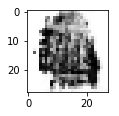

Estimate: [[0.26066768]]
Iteration: 3500 at 2019-10-05 14:21:43.129791


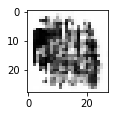

Estimate: [[-12.450367]]
Iteration: 3600 at 2019-10-05 14:21:48.380720


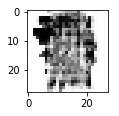

Estimate: [[-4.74652]]
Iteration: 3700 at 2019-10-05 14:21:53.632498


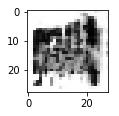

Estimate: [[-6.810144]]
Iteration: 3800 at 2019-10-05 14:21:58.904355


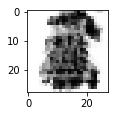

Estimate: [[-4.2845435]]
Iteration: 3900 at 2019-10-05 14:22:04.166144


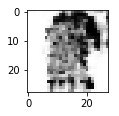

Estimate: [[6.8147807]]
Iteration: 4000 at 2019-10-05 14:22:09.429997


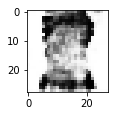

Estimate: [[-2.9787617]]
Iteration: 4100 at 2019-10-05 14:22:14.767930


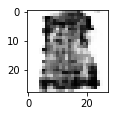

Estimate: [[2.3353043]]
Iteration: 4200 at 2019-10-05 14:22:20.048323


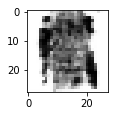

Estimate: [[0.5868671]]
Iteration: 4300 at 2019-10-05 14:22:25.509101


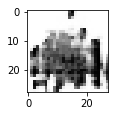

Estimate: [[1.5741351]]
Iteration: 4400 at 2019-10-05 14:22:30.745615


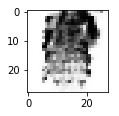

Estimate: [[-4.426597]]
Iteration: 4500 at 2019-10-05 14:22:36.007353


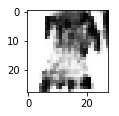

Estimate: [[-2.8725886]]
Iteration: 4600 at 2019-10-05 14:22:41.294648


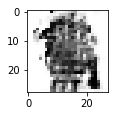

Estimate: [[-14.335211]]
Iteration: 4700 at 2019-10-05 14:22:46.606646


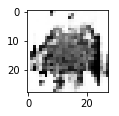

Estimate: [[5.0417476]]
Iteration: 4800 at 2019-10-05 14:22:51.891125


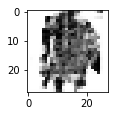

Estimate: [[1.0547541]]
Iteration: 4900 at 2019-10-05 14:22:57.178073


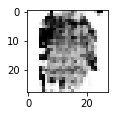

Estimate: [[-6.0074058]]
Iteration: 5000 at 2019-10-05 14:23:02.486367


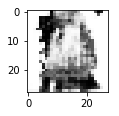

Estimate: [[3.1822433]]
Iteration: 5100 at 2019-10-05 14:23:07.813652


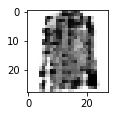

Estimate: [[-18.871138]]
Iteration: 5200 at 2019-10-05 14:23:13.176606


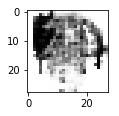

Estimate: [[-1.3158921]]
Iteration: 5300 at 2019-10-05 14:23:18.516956


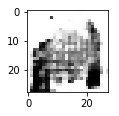

Estimate: [[-6.613876]]
Iteration: 5400 at 2019-10-05 14:23:23.875724


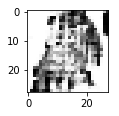

Estimate: [[-12.250632]]
Iteration: 5500 at 2019-10-05 14:23:29.224210


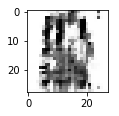

Estimate: [[3.8700495]]
Iteration: 5600 at 2019-10-05 14:23:34.576359


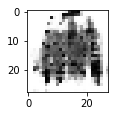

Estimate: [[-3.2547169]]
Iteration: 5700 at 2019-10-05 14:23:39.926386


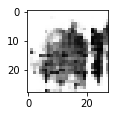

Estimate: [[-0.0755831]]
Iteration: 5800 at 2019-10-05 14:23:45.292192


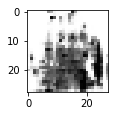

Estimate: [[-7.224769]]
Iteration: 5900 at 2019-10-05 14:23:50.660768


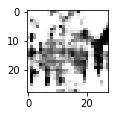

Estimate: [[3.223998]]
Iteration: 6000 at 2019-10-05 14:23:56.031277


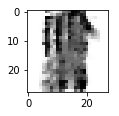

Estimate: [[-1.6559805]]
Iteration: 6100 at 2019-10-05 14:24:01.439748


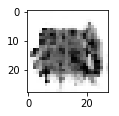

Estimate: [[-3.183853]]
Iteration: 6200 at 2019-10-05 14:24:06.843409


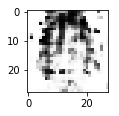

Estimate: [[-2.7151575]]
Iteration: 6300 at 2019-10-05 14:24:12.271298


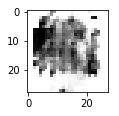

Estimate: [[-0.8090358]]
Iteration: 6400 at 2019-10-05 14:24:17.693656


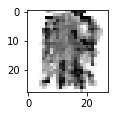

Estimate: [[-7.5954914]]
Iteration: 6500 at 2019-10-05 14:24:23.116893


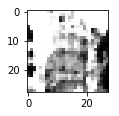

Estimate: [[-1.6914432]]
Iteration: 6600 at 2019-10-05 14:24:28.579779


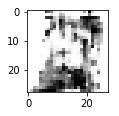

Estimate: [[12.517829]]
Iteration: 6700 at 2019-10-05 14:24:34.252728


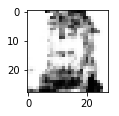

Estimate: [[1.5058463]]
Iteration: 6800 at 2019-10-05 14:24:39.680089


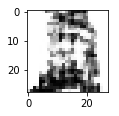

Estimate: [[-5.946069]]
Iteration: 6900 at 2019-10-05 14:24:45.127419


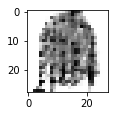

Estimate: [[-3.5345955]]
Iteration: 7000 at 2019-10-05 14:24:50.599079


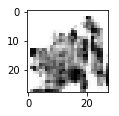

Estimate: [[9.254226]]
Iteration: 7100 at 2019-10-05 14:24:56.046809


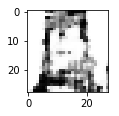

Estimate: [[18.407688]]
Iteration: 7200 at 2019-10-05 14:25:01.573141


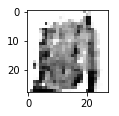

Estimate: [[-5.3090086]]
Iteration: 7300 at 2019-10-05 14:25:07.104324


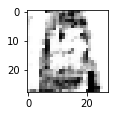

Estimate: [[18.869993]]
Iteration: 7400 at 2019-10-05 14:25:12.594052


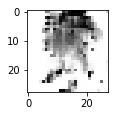

Estimate: [[0.60978675]]
Iteration: 7500 at 2019-10-05 14:25:18.065654


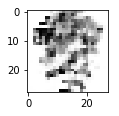

Estimate: [[-11.997367]]
Iteration: 7600 at 2019-10-05 14:25:23.549224


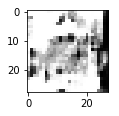

Estimate: [[12.883543]]
Iteration: 7700 at 2019-10-05 14:25:29.025184


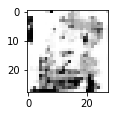

Estimate: [[-8.409358]]
Iteration: 7800 at 2019-10-05 14:25:34.540186


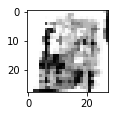

Estimate: [[15.620028]]
Iteration: 7900 at 2019-10-05 14:25:40.021268


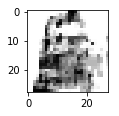

Estimate: [[14.571443]]
Iteration: 8000 at 2019-10-05 14:25:45.593725


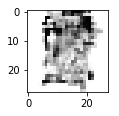

Estimate: [[-5.8193145]]
Iteration: 8100 at 2019-10-05 14:25:51.104388


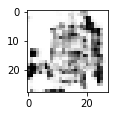

Estimate: [[6.5255027]]
Iteration: 8200 at 2019-10-05 14:25:56.631235


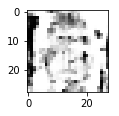

Estimate: [[16.6468]]
Iteration: 8300 at 2019-10-05 14:26:02.144125


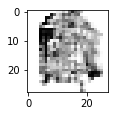

Estimate: [[-14.815607]]
Iteration: 8400 at 2019-10-05 14:26:07.660968


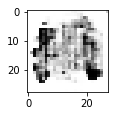

Estimate: [[-16.073395]]
Iteration: 8500 at 2019-10-05 14:26:13.262009


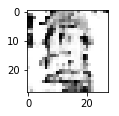

Estimate: [[-26.632181]]
Iteration: 8600 at 2019-10-05 14:26:18.825696


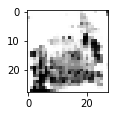

Estimate: [[2.2915099]]
Iteration: 8700 at 2019-10-05 14:26:24.426739


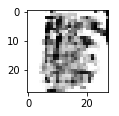

Estimate: [[5.785442]]
Iteration: 8800 at 2019-10-05 14:26:29.975942


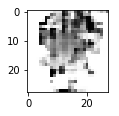

Estimate: [[-7.8106585]]
Iteration: 8900 at 2019-10-05 14:26:35.537293


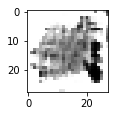

Estimate: [[0.37607774]]
Iteration: 9000 at 2019-10-05 14:26:41.099149


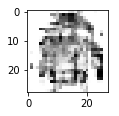

Estimate: [[-4.494733]]
Iteration: 9100 at 2019-10-05 14:26:46.844946


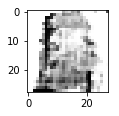

Estimate: [[-7.9846764]]
Iteration: 9200 at 2019-10-05 14:26:52.445225


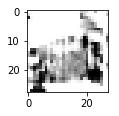

Estimate: [[-0.76849216]]
Iteration: 9300 at 2019-10-05 14:26:58.070038


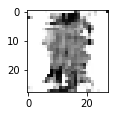

Estimate: [[-8.790374]]
Iteration: 9400 at 2019-10-05 14:27:03.718807


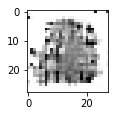

Estimate: [[-4.8658905]]
Iteration: 9500 at 2019-10-05 14:27:09.569226


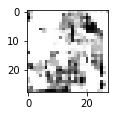

Estimate: [[-5.0773773]]
Iteration: 9600 at 2019-10-05 14:27:15.265201


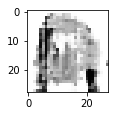

Estimate: [[-3.6872258]]
Iteration: 9700 at 2019-10-05 14:27:20.908661


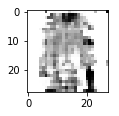

Estimate: [[7.4716496]]
Iteration: 9800 at 2019-10-05 14:27:26.535115


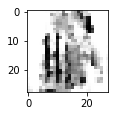

Estimate: [[-17.34753]]
Iteration: 9900 at 2019-10-05 14:27:32.210831


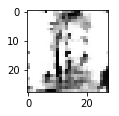

Estimate: [[0.17748046]]
Iteration: 10000 at 2019-10-05 14:27:37.874630


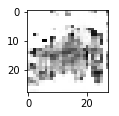

Estimate: [[-2.0680163]]
Iteration: 10100 at 2019-10-05 14:27:43.546854


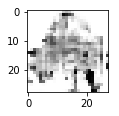

Estimate: [[7.5020924]]
Iteration: 10200 at 2019-10-05 14:27:49.211930


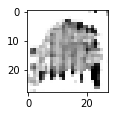

Estimate: [[-8.157702]]
Iteration: 10300 at 2019-10-05 14:27:54.891147


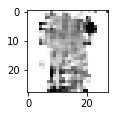

Estimate: [[5.9745684]]
Iteration: 10400 at 2019-10-05 14:28:00.601654


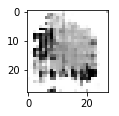

Estimate: [[-4.9984345]]
Iteration: 10500 at 2019-10-05 14:28:06.320231


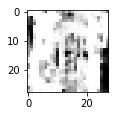

Estimate: [[18.082312]]
Iteration: 10600 at 2019-10-05 14:28:12.011090


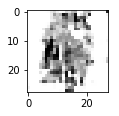

Estimate: [[-4.457033]]
Iteration: 10700 at 2019-10-05 14:28:17.763516


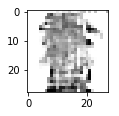

Estimate: [[6.5514617]]
Iteration: 10800 at 2019-10-05 14:28:23.464546


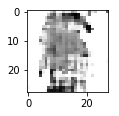

Estimate: [[-10.898896]]
Iteration: 10900 at 2019-10-05 14:28:29.187086


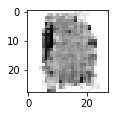

Estimate: [[0.49500966]]
Iteration: 11000 at 2019-10-05 14:28:34.890630


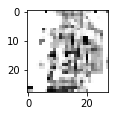

Estimate: [[-1.4503825]]
Iteration: 11100 at 2019-10-05 14:28:40.630945


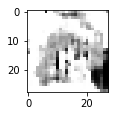

Estimate: [[-21.62451]]
Iteration: 11200 at 2019-10-05 14:28:46.436781


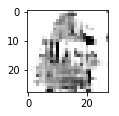

Estimate: [[-6.373166]]
Iteration: 11300 at 2019-10-05 14:28:52.204609


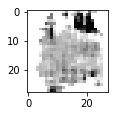

Estimate: [[13.168497]]
Iteration: 11400 at 2019-10-05 14:28:57.970842


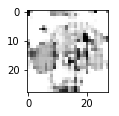

Estimate: [[-4.635557]]
Iteration: 11500 at 2019-10-05 14:29:03.745589


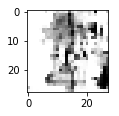

Estimate: [[16.590649]]
Iteration: 11600 at 2019-10-05 14:29:09.508875


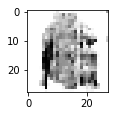

Estimate: [[6.2247863]]
Iteration: 11700 at 2019-10-05 14:29:15.304970


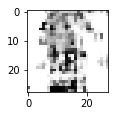

Estimate: [[-3.8637788]]
Iteration: 11800 at 2019-10-05 14:29:21.156079


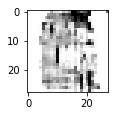

Estimate: [[0.98824006]]
Iteration: 11900 at 2019-10-05 14:29:26.949447


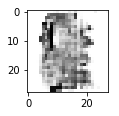

Estimate: [[-14.482137]]
Iteration: 12000 at 2019-10-05 14:29:32.755935


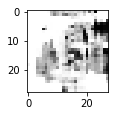

Estimate: [[10.632427]]
Iteration: 12100 at 2019-10-05 14:29:38.572687


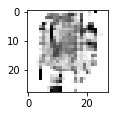

Estimate: [[-26.573782]]
Iteration: 12200 at 2019-10-05 14:29:44.359924


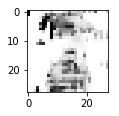

Estimate: [[-1.9590981]]
Iteration: 12300 at 2019-10-05 14:29:50.190888


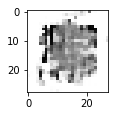

Estimate: [[-27.672218]]
Iteration: 12400 at 2019-10-05 14:29:56.032207


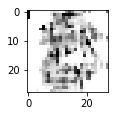

Estimate: [[-12.7353735]]
Iteration: 12500 at 2019-10-05 14:30:01.859681


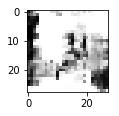

Estimate: [[79.1404]]
Iteration: 12600 at 2019-10-05 14:30:07.718079


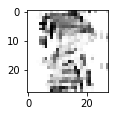

Estimate: [[7.860001]]
Iteration: 12700 at 2019-10-05 14:30:13.685769


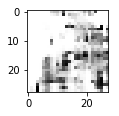

Estimate: [[26.574762]]
Iteration: 12800 at 2019-10-05 14:30:19.875832


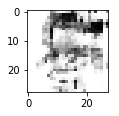

Estimate: [[-17.708584]]
Iteration: 12900 at 2019-10-05 14:30:25.814865


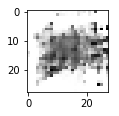

Estimate: [[-2.2602897]]
Iteration: 13000 at 2019-10-05 14:30:31.713926


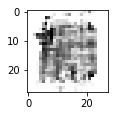

Estimate: [[-29.74412]]
Iteration: 13100 at 2019-10-05 14:30:37.603666


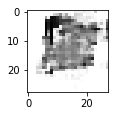

Estimate: [[-15.142561]]
Iteration: 13200 at 2019-10-05 14:30:43.506643


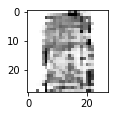

Estimate: [[2.2374954]]
Iteration: 13300 at 2019-10-05 14:30:49.484262


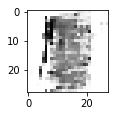

Estimate: [[-6.357884]]
Iteration: 13400 at 2019-10-05 14:30:55.466109


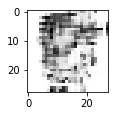

Estimate: [[10.672261]]
Iteration: 13500 at 2019-10-05 14:31:01.367800


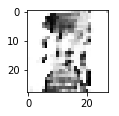

Estimate: [[4.965001]]
Iteration: 13600 at 2019-10-05 14:31:07.315320


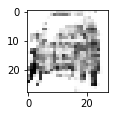

Estimate: [[0.99324465]]
Iteration: 13700 at 2019-10-05 14:31:13.276263


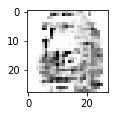

Estimate: [[10.767678]]
Iteration: 13800 at 2019-10-05 14:31:19.204977


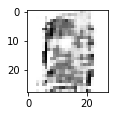

Estimate: [[1.069808]]
Iteration: 13900 at 2019-10-05 14:31:25.162784


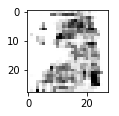

Estimate: [[13.662192]]
Iteration: 14000 at 2019-10-05 14:31:31.156255


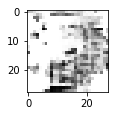

Estimate: [[-5.9476438]]
Iteration: 14100 at 2019-10-05 14:31:37.092902


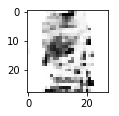

Estimate: [[-13.2141905]]
Iteration: 14200 at 2019-10-05 14:31:43.034685


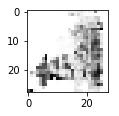

Estimate: [[38.651066]]
Iteration: 14300 at 2019-10-05 14:31:49.044229


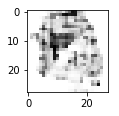

Estimate: [[4.727177]]
Iteration: 14400 at 2019-10-05 14:31:55.057011


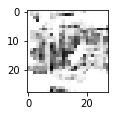

Estimate: [[-14.22179]]
Iteration: 14500 at 2019-10-05 14:32:01.036079


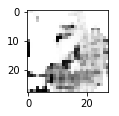

Estimate: [[-2.169155]]
Iteration: 14600 at 2019-10-05 14:32:07.056165


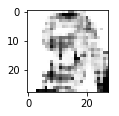

Estimate: [[-10.996756]]
Iteration: 14700 at 2019-10-05 14:32:13.074165


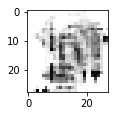

Estimate: [[9.594544]]
Iteration: 14800 at 2019-10-05 14:32:19.087978


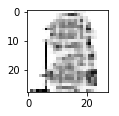

Estimate: [[-1.4612603]]
Iteration: 14900 at 2019-10-05 14:32:25.123263


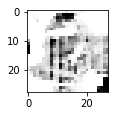

Estimate: [[-17.756027]]
Iteration: 15000 at 2019-10-05 14:32:31.150919


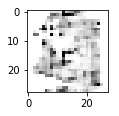

Estimate: [[-31.379837]]
Iteration: 15100 at 2019-10-05 14:32:37.233826


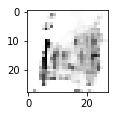

Estimate: [[-2.006435]]
Iteration: 15200 at 2019-10-05 14:32:43.280707


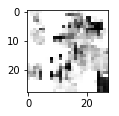

Estimate: [[-23.187046]]
Iteration: 15300 at 2019-10-05 14:32:49.352746


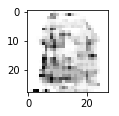

Estimate: [[-4.7884626]]
Iteration: 15400 at 2019-10-05 14:32:55.414079


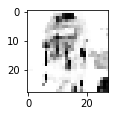

Estimate: [[8.605994]]
Iteration: 15500 at 2019-10-05 14:33:01.476869


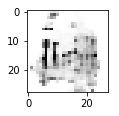

Estimate: [[-8.31875]]
Iteration: 15600 at 2019-10-05 14:33:07.557568


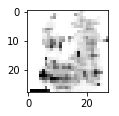

Estimate: [[0.49351364]]
Iteration: 15700 at 2019-10-05 14:33:13.671513


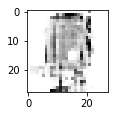

Estimate: [[-33.724728]]
Iteration: 15800 at 2019-10-05 14:33:19.774653


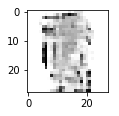

Estimate: [[0.9604616]]
Iteration: 15900 at 2019-10-05 14:33:25.848626


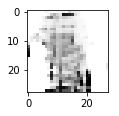

Estimate: [[-26.90785]]
Iteration: 16000 at 2019-10-05 14:33:31.964141


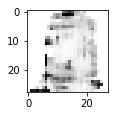

Estimate: [[-13.176929]]
Iteration: 16100 at 2019-10-05 14:33:38.145240


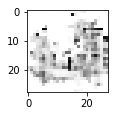

Estimate: [[-49.17377]]
Iteration: 16200 at 2019-10-05 14:33:44.288951


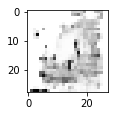

Estimate: [[-16.156872]]
Iteration: 16300 at 2019-10-05 14:33:50.441226


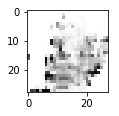

Estimate: [[24.77995]]
Iteration: 16400 at 2019-10-05 14:33:56.602612


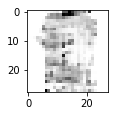

Estimate: [[-24.87715]]
Iteration: 16500 at 2019-10-05 14:34:02.768626


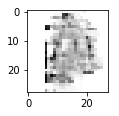

Estimate: [[-7.16722]]
Iteration: 16600 at 2019-10-05 14:34:08.927045


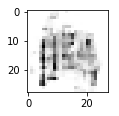

Estimate: [[-11.822582]]
Iteration: 16700 at 2019-10-05 14:34:15.409464


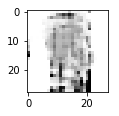

Estimate: [[1.1389143]]
Iteration: 16800 at 2019-10-05 14:34:21.592526


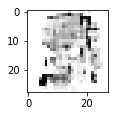

Estimate: [[-46.520435]]
Iteration: 16900 at 2019-10-05 14:34:27.778809


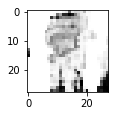

Estimate: [[-1.6573793]]


KeyboardInterrupt: ignored

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
plt.figure(figsize=(1,1))

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.figure(figsize=(1.5,1.5))
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)